In [ ]:
import numpy as np
import pandas as pd
from IPython.display import Image
Image(url='http://datascience.uci.edu/wp-content/uploads/sites/2/2014/09/data_science_logo_with_image1.png')

## Predictive Modeling with Python - Overfitting, Regularization, Model Selection
#### Author: Kevin Bache

## Before Lunch:
We created a linear model and saw that it performed well on already seen data but poorly on unseen data.

## Predictive Modeling
What we saw above is a common setup.  We have $\mathbf{X}$ and $\mathbf{y}$ data from the past and $\mathbf{X}$ data for the present for which we want to **predict** the future $\mathbf{y}$ values.

We can generalize this notion of past / present data into what's generally called **train** and **test** data.

* **Training Data** -- A dataset that we use to train our model.  We have both $\mathbf{X}$ and $\mathbf{y}$
* **Testing Data** -- A dataset which only has $\mathbf{X}$ values and for which we need to predict $\mathbf{y}$ values.  We might also have access to the real $\mathbf{y}$ values so that we can test how well our model will perform on data it hasn't seen before.

### <span style="color:red">Model Fitting Exercise: 8 Minutes</span>
1. Partner up.  On one computer:
  1. Write a function with the call signature `predict_test_values(model, x_train, y_train, x_test)` where `model` is a scikit learn model
    1. Fit the model on `x_train` and `y_train`
    1. Predict the y values for `X_test`
    1. Return a vector of predicted y values
  1. Write a second function with the call signature `calc_train_and_test_error(model, x_train, y_train, x_test, y_test)`
    1. Fit the model on `x_train` and `y_train`
    1. Predict the y values for `x_test`
    1. Predict the y values for `x_train`
    1. Calculate the `mean_squared_error` on both the train and test data.
    1. Return the train error and test error
  1. Describe to your partner the situations in which you might use each function

In [ ]:
def mean_squared_error(y_true, y_pred):
    """
    calculate the mean_squared_error given a vector of true ys and a vector of predicted ys
    """
    diff = y_true - y_pred
    return np.dot(diff, diff) / len(diff)

def predict_test_values(model, X_train, y_train, X_test):
    pass

def calc_train_and_test_error(model, X_train, y_train, X_test, y_test):
    pass

## The Central Theses of Machine Learning
###<span style="color:green">**1) A predictive model is only as good as its predictions on unseen data **</span>
###<span style="color:green">**2) Error on the dataset we trained on is not a good predictor of error on future data**</span>

Why isn't error on the training data a good indicator of future performance?  Overfitting.

### Overfitting in One Picture

In [ ]:
Image(url='http://radimrehurek.com/data_science_python/plot_bias_variance_examples_2.png')

## How to Fight Overfitting?
Ultimately we don't want to build a model which performs well on data we've already seen, we want to build a model which will perform well on data we haven't seen.

There are two linked strategies for to accomplish this: **regularization** and **model selection**.

## Regularization
The idea in regularization is that we're going to modify our loss function to penalize it for being too complex. Simple models are better.

One way to do this is to try to keep our regression coefficients small. Why would we want to do this? One intuitive explanation is that if we have big regression coefficients we'll get large changes in the predicted values from small changes in input value.  That's bad. Intuitively, our predictions should vary smoothly with the data.

So a model with smaller coefficients makes smoother predictions.  It is simpler, which means it will have a harder time overfitting. 

We can change our linear regression loss function to help us reduce overfitting:

###Linear Regression Loss Function
\begin{eqnarray*}
    Loss(\beta) = MSE &=& \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat y_i)^2 \\
    &=& \frac{1}{N} \sum_{i=1}^{N} (y_i - x_i^T\beta)^2 \\   
\end{eqnarray*}

###L2 Regularized Linear Regression Loss Function -- "Ridge"
\begin{eqnarray*}
    Loss(\beta) &=& \frac{1}{N} \sum_{i=1}^{N} (y_i - x_i^T\beta)^2 + \alpha ||\beta||_2^2\\
    &=& \frac{1}{N} \sum_{i=1}^{N} (y_i - x_i^T\beta)^2 + \alpha \beta^T \beta\\
    &=& \frac{1}{N} \sum_{i=1}^{N} (y_i - x_i^T\beta)^2 + \alpha \sum_{d=1}^D \beta_d^2\\
\end{eqnarray*}

We won't get into details, but a ridge regression model can be optimized in much the same way as an unregularized linear regression: either with using some form of gradient descent or matrix-based solutions. 

In [ ]:
# Ridge Regression in scikit-learn
from sklearn import linear_model
model_ridge = linear_model.Ridge(alpha = .5)

# once it's been fit, you can look at the learned beta values of the model with: model_ridge.coef_

### <span style="color:red">Ridge Regression Errors: 6 Minutes</span>
1. Partner up.  On one computer:
  1. Using your `calc_train_and_test_error` function from the previous exercise:
    1. Calculate the training and testing error for a LinearRegression model on the dataset below
    1. Calculate the training and testing error for a Ridge regression model with `alpha=1` on the dataset below
  1. Add up the absolute values of the coefficients of each model. Which is bigger?

     **Note:** If you have a fit model called `m`, then you can access a vector holding its learned coefficients with `m.coef_`.  
      
     **Note:** Check out the functions `np.sum()` and `np.abs()`

  1. Discuss with your partner what's happening here

In [22]:
# load overfitting data
with np.load('data/overfitting_data.npz') as data:
    x_train = data['x_train']
    y_train = data['y_train']
    x_test = data['x_test']
    y_test = data['y_test']
    
# YOUR CODE HERE!

###L1 Regularized Linear Regression Loss Function -- "LASSO"
LASSO is another regularization method.  It penalizes not with the square of the regression coefficients (the $\beta$s) but with their absolute values.

LASSO has the additional property that it tends to push beta values of unimportant dimensions all the way to exactly 0.  This has the beneficial property of enforcing sparsity in our model.  If having lots of small coefficients leads to a simpler model, having lots of 0-valued coefficients lead to even simpler models.

\begin{eqnarray*}
    Loss(\beta) &=& \frac{1}{N} \sum_{i=1}^{N} (y_i - x_i^T\beta)^2 + \alpha ||\beta||_1\\
    &=& \frac{1}{N} \sum_{i=1}^{N} (y_i - x_i^T\beta)^2 + \alpha \sum_{d=1}^D |\beta_d|\\
\end{eqnarray*}

In [ ]:
# LASSO in scikit-learn
from sklearn import linear_model
model_lasso = linear_model.Lasso(alpha = 0.5)

### <span style="color:red">LASSO Coefficients and Errors: 6 Minutes</span>
1. Partner up.  On one computer:
  1. Using your `calc_train_and_test_error` again, calculate the training and testing error for a LASSO model with `alpha=1` on the dataset from the previous exercise
  1. Add up the absolute values of the coefficients of the LASSO model. Compare it to the coefficient sums from the `LinearRegression` and `Ridge` models.
  1. Look at the first 10 coefficients of the `LinearRegression`, `Ridge`, and `LASSO` models.  
  1. Discuss with your partner what's happening here

In [23]:
# Write your code here

###L1 + L2 Regularized Linear Regression Loss Function -- "ElasticNet"
\begin{eqnarray*}
    Loss(\beta) &=& \frac{1}{2N} \sum_{i=1}^{N} (y_i - x_i^T\beta)^2 + \alpha \rho ||\beta||_1 + \frac{\alpha (1 - \rho)}{2} ||\beta||_2^2\\\\
    &=& \frac{1}{2N} \sum_{i=1}^{N} (y_i - x_i^T\beta)^2 + \alpha \rho \sum_{d=1}^D |\beta_d| + \frac{\alpha (1 - \rho)}{2} \sum_{d=1}^D \beta_d^2\\
\end{eqnarray*}

In [ ]:
from sklearn import linear_model
model_en = linear_model.ElasticNet(alpha=0.5, l1_ratio=0.1)

# note: scikit learn's current implementation of ElasticNet isn't stable with l1_ratio <= 0.01

### <span style="color:red">ElasticNet Coefficients and Errors: 4 Minutes</span>
1. Partner up.  On one computer:
  1. Using your `calc_train_and_test_error` again, calculate the training and testing error for an `ElasticNet` model with `alpha=1` and `l1_ratio=0.5` on the dataset from the previous exercises
  1. Add up the absolute values of the first 10 coefficients of the `ElasticNet` model. Compare it to the sums from the `LinearRegression`, `Ridge`, and `LASSO` models.
  1. Look at the first 10 coefficients of the `ElasticNet` model.  
  1. Discuss with your partner what's happening here

In [ ]:
# Write your code here

## Cross Validation
Now we know three types of regularization for linear regression: ridge regression, LASSO, and elastic net.  

All of our regularized models had better test error that simple linear regression.  But how should we choose which model to ultimatley use or which parameters to use?  The answer is through careful use of **cross validation**.

There are many forms of cross validation, but the basic idea of each is to _train_ your model on some data and _estimate it's future performance_ on other data.

## Types of Cross Validation
### Validation Set Cross Validation
1. Pick an amount of training data to be in your validation data set (e.g. 10%)
2. Randomly split datapoints into training points (90%) and validation points (10%)
3. Train your model on the training data
4. Test your model on the validation data, record the validation error
5. Estimated future errors is the validation error


* **Good:** Easy and computationally cheap
* **Bad:** Statistically noisy and wastes data


**Aside:** So far we've been calculating error on out test dataset.  This is conceptually almost identical to using a validation set, but with two significant differences:
1. We don't have to peek at our test data set.  This is good because if we do that too much, we can actually still overfit to our test data and still perform poorly on future unseen data.
1. We don't have to be given the $\mathbf{y}$ vector for our test dataset. Validation set cross validation only requires a training dataset.

In [ ]:
# a helper function for performing validation set cross validation
from sklearn.cross_validation import train_test_split
validation_portion = 0.1
seed = 1234
x_train_small, x_valid, y_train_small, y_valid = \
    train_test_split(x_train, y_train, test_size=validation_portion, random_state=seed)

print 'Original Training Set Size:'
print x_train.shape, y_train.shape
print

print 'Reducted Training Set Size:'
print x_train_small.shape, y_train_small.shape
print

print 'Validation Set Size:'
print x_valid.shape, y_valid.shape
print


#### <span style="color:red">Validation Set Cross Validation Exercise: 13 Minutes</span>
1. Partner up.  On one computer:
  1. Write a function with the call signature `validation_set_error(model, x_train, y_train, validation_portion=0.1, seed=1234)` which returns the validation set estimate of the future error for the given `model`. This function should:
    1. Split the data into a reduced training set and a validation set
    1. Train on the reduced training set
    1. Estimate the mean squared error on the validation set
    1. Return that estimate
  1. Use your `calc_train_and_test_error(model, x_train, y_train, x_test, y_test)` function to calculate training and test set errors for these 
  1. Use this your `validation_set_error` function to estimate the future error on the overfitting data for:
    1. A linear regression model
    1. A ridge regression models with `alpha` = 10
  1. Do this for multiple random seeds
  1. Does validation error do a good job of predicting test error?
  1. If you have time: How does changing the validation_portion affect the similarity between the validation and test error?


In [18]:
def validation_set_error(model, x_train, y_train, validation_portion=0.1, seed=1234):
    pass

Linear Regression Training and Test Errors:
(2.4835421623895294e-05, 283.52728792173548)

Linear Regression Validation Errors:
9.44958288788

11.534546517

11.8057845076

10.7606395757

7.60088829288

Ridge Regression Training and Test Errors:
(0.06406324343262465, 4.9205415455727231)

Ridge Regression Validation Errors:
3.61817500364

7.12476980873

5.32580668571

5.74292650031

4.6239411424



### K-Fold Cross Validation
K-Fold cross validation is another cross validation method for estimating the out-of-sample error of a model.  It works like this:

1. Partition the training data into K folds
2. For each fold k in 1 to K:
  1. Train the model on all your data except the data in fold k
  2. Record the error on the the data in fold k
3. Estimate future error as average error across all folds

In [ ]:
Image(url='https://chrisjmccormick.files.wordpress.com/2013/07/10_fold_cv.png')

* **Good:** Only wastes 100/k% of the data at a time
* **Bad:** Takes k times long as just training one model, still wastes 100/k% of the data

In [14]:
# scikit learn provides a useful object to help you perform kfold cross validation
from sklearn.cross_validation import KFold

n_data = len(y_train)
fold_count = 0
for train_reduced_row_ids, valid_row_ids in KFold(n_data, n_folds=4):
    print
    print 
    print "FOLD %d:" % fold_count
    print "-------"
    print("train_ids:\n%s\n\nvalid_ids\n%s" % (train_reduced_row_ids, valid_row_ids))
    x_train_reduced = x_train[train_reduced_row_ids]
    y_train_reduced = y_train[train_reduced_row_ids]
    x_valid = x_train[valid_row_ids]
    y_valid = y_train[valid_row_ids]
    fold_count += 1



FOLD 0:
-------
train_ids:
[150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275
 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293
 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329
 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347
 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365
 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383
 384 385 386 387 388 3

In [15]:
# NOTE: KFolds isn't random at all.  It's important to shuffle your data first before using it. 
from sklearn.utils import shuffle
x_train_shuffled, y_train_shuffled = shuffle(x_train, y_train)

#### <span style="color:red">K-Fold Cross Validation Exercise: 17 Minutes</span>
1. Partner up.  On one computer:
  1. Write a function with the call signature `kfold_error(model, x_train, y_train, k=4, seed=1234)` which returns the k-fold cross validation estimate of the future error for the given `model`. This function should:
    1. Shuffle the training data set (both $\mathbf{x}$ and  $\mathbf{y}$ in unison)
    1. For each fold:
        1. Split the data into a reduced training set and a validation set
        1. Train on the reduced training set
        1. Estimate the mean squared error on the validation set
        1. Add the estimated error to a running sum of the estimated total error
    1. Return the average error across folds: i.e.: the estimated total error divided by the number of folds
  1. Use your `calc_train_and_test_error(model, x_train, y_train, x_test, y_test)` function to calculate training and test set errors for these 
  1. Use your `kfold_error` function with k=5 to estimate the future error on the overfitting data for:
    1. A linear regression model
    1. A ridge regression models with `alpha` = 10
  1. Do this for multiple random seeds
  1. Does k-fold error do a good job of predicting test error?

In [19]:
def kfold_error(model, x_train, y_train, k=4, seed=1234):
    pass

Linear Regression Training and Test Errors:
(2.4835421623895294e-05, 283.52728792173548)

Linear Regression K-Fold Errors:
7.31564649535

7.21893723847

6.89253599587

Ridge Regression Training and Test Errors:
(0.06406324343262465, 4.9205415455727231)

Ridge Regression K-Fold Errors:
5.77769677178

5.78170553945

5.6587338965



## Putting It All Together: Model and Hyperparameter Selection with Cross Validation
1. For each model and hyperparameter combo you're willing to consider:
  1. Estimate the model's performance on future data using cross validation
2. Pick the model with the best estimated future performance
3. Train the best model from scratch on the full dataset.  This is your final model

In [20]:
def model_name(model):
    s = model.__str__().lower()
    if "linearregression" in s:
        return 'LinearRegression'
    elif "lasso" in s:
        return 'Lasso(a=%g)' % model.alpha
    elif "ridge" in s:
        return 'Ridge(a=%g)' % model.alpha
    elif "elastic" in s:
        return 'ElasticNet(a=%g, r=%g)' % (model.alpha, model.l1_ratio)
    else:
        raise ValueError("Unknown Model Type")

def create_models(alphas=(.01, .03, .1, .3, 1, 3), l1_ratios=(.7, .5, .3)):
    models = [linear_model.LinearRegression()]
    models.extend([linear_model.Ridge(a) for a in alphas])
    models.extend([linear_model.Lasso(a) for a in alphas])
    models.extend([linear_model.ElasticNet(a, l1_ratio=l) for a in alphas for l in l1_ratios])
    return models

def results_df(models, betas_true, x_train, y_train, x_test, y_test, k=4):
    n_data, n_dim = x_train.shape

    n_zeros = n_dim - len(betas_true)
    
    betas_true = np.concatenate([betas_true, np.zeros(n_zeros)])
    
    # fit models to training data
    [m.fit(x_train, y_train) for m in models]
    
    betas = np.vstack([betas_true] + [m.coef_ for m in models])
    beta_names = ['Beta ' + str(i) for i in range(n_dim)]

    # set up model names
    model_names =  ["True Coefs"] + [model_name(m) for m in models]
    df = pd.DataFrame(data=betas, columns=beta_names, index=model_names)

    # calculate training errors
    y_preds = [m.predict(x_train) for m in models]
    errors = [np.nan] + [mean_squared_error(y_train, y_pred) for y_pred in y_preds]
    df['Train Error'] = errors

    # calculate validation errors
    errors = [np.nan] + [kfold_error(m, x_train, y_train, k=k) for m in models]
    df['Cross Validation Error'] = errors

    # calculate test errors
    y_preds = [m.predict(x_test) for m in models]
    errors = [np.nan] + [mean_squared_error(y_test, y_pred) for y_pred in y_preds]
    df['Test Error'] = errors

    return df


# these are some of the magic parameters that I used to actually 
# generate the overfitting dataset
n_dim = 598
n_dim_meaningful = 3
n_dim_disp_extra = 2

# the actual betas used to generate the y values.  the rest were 0.
betas_true = np.arange(n_dim_meaningful) + 1

# create a whole bunch of untrained models
models = create_models(alphas=(.01, .03, .1, .3, 1), l1_ratios=(.9, .7, .5))

# 
all_results = results_df(models, betas_true, x_train, y_train, x_test, y_test, k=4)

# decide which columns we want to display
disp_cols = ["Beta " + str(i) for i in range(n_dim_meaningful + n_dim_disp_extra)] 
disp_cols += ['Train Error', 'Cross Validation Error', 'Test Error']

# display the results
all_results[disp_cols]

,Beta 0,Beta 1,Beta 2,Beta 3,Beta 4,Train Error,Cross Validation Error,Test Error
True Coefs,1.000000,2.000000,3.000000,0.000000,0.000000,NaN,NaN,NaN
LinearRegression,0.522757,2.782898,4.043838,1.175442,0.313231,0.000025,7.093499,10.183823
Ridge(a=0.01),0.867059,2.290546,3.729941,0.570987,0.380292,0.001033,6.590630,8.592261
Ridge(a=0.03),1.028546,2.023949,3.548358,0.237767,0.370161,0.002749,6.588766,8.590441
Ridge(a=0.1),1.088696,1.847044,3.386562,0.012841,0.272410,0.005693,6.582288,8.584100
Ridge(a=0.3),1.065763,1.788885,3.247394,-0.050784,0.142292,0.010186,6.564170,8.566235
Ridge(a=1),1.016116,1.772469,3.065348,-0.033390,0.043787,0.018634,6.504991,8.506474
Lasso(a=0.01),1.076240,1.956283,2.955116,0.000000,0.025530,0.213388,1.701747,1.849997
Lasso(a=0.03),1.042435,1.941418,2.952131,0.000000,0.002460,0.526780,1.223279,1.196381
Lasso(a=0.1),0.972258,1.869852,2.892761,-0.000000,0.000000,0.968836,1.024546,0.895046


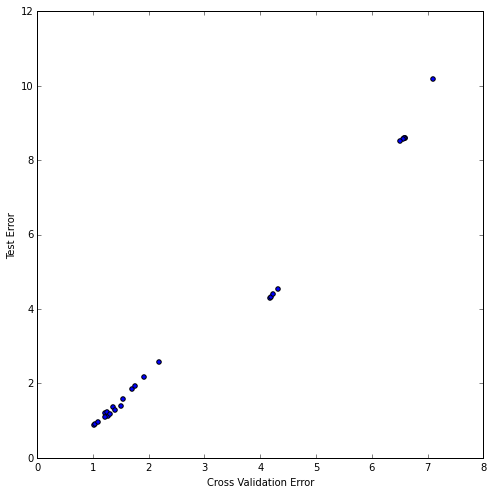

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
f = plt.figure()
plt.scatter(all_results['Cross Validation Error'], all_results['Test Error'])
plt.xlabel('Cross Validation Error')
plt.ylabel('Test Error')
f.set_size_inches(8, 8)
plt.show()

In [ ]:
# scikit learn includes some functions for making cross validation easier 
# and computationally faster for a some models
from sklearn import linear_model
model_ridge_cv = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0])
model_lasso_cv = linear_model.LassoCV(alphas=[0.1, 1.0, 10.0])
model_en_cv = linear_model.ElasticNetCV(l1_ratio=[.9], n_alphas=100)

## Caveats:
* You can still overfit with intensive cross validation based model selection!
* But it's much better than without

## Summary:
* **The Central Theses of Machine Learning:** 
  * We're only interested in predictive performance on unseen data, not on seen data.
  * **Training error** estimates error on **seen** data
  * **Cross validation error** estimates error on **unseen** data
* **Regularization** strategies change how to train a model so that it will perform better on unseen data
* We talked about three forms of regularization for linear regression:
  * **Ridge Regression** (L2 Penalty)
  * **LASSO** (L1 Penalty)
  * **ElasticNet** (L1 + L2 Penalties)
* We talked about two kinds of cross validation error:
  * **Validation Error** -- split your training set into a reduced training set and a validation set
  * **K-Fold Error** -- Split your training data into k reduced training sets and a validation sets
* Regularization introduces new hyperparameters
* Use a cross validated estimate of future performance to choose your model and hyperparameter settings